In [2]:
import chess
import chess.engine
import numpy as np
import random
from tqdm import tqdm
from stockfish import Stockfish
from collections import deque
import matplotlib.pyplot as plt

100%|██████████| 10000/10000 [3:46:15<00:00,  1.36s/it] 

AgentWin: 0
StockfishWin: 10000
Draw: 0
Average Reward: -0.0001
Average Reward on Episodes: -1.0429


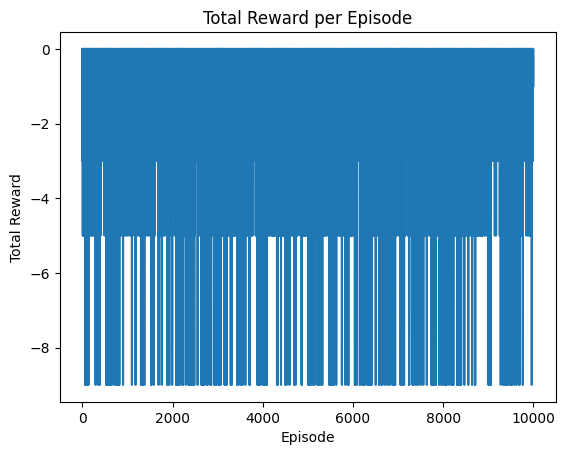

CPU times: total: 2min 19s
Wall time: 3h 46min 16s


In [6]:
%%time

# Define the RL agent class
class RLAgent:
    def __init__(self, alpha=0.7, gamma=0.9, epsilon=0.5, max_q_values=100):
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.max_q_values = max_q_values  # Maximum number of Q-values to keep
        self.q_values = deque(maxlen=max_q_values)  # Q-values history
        self.total_reward = 0  # Total reward obtained by the agent
        self.num_games = 0  # Number of games played
        self.episode_rewards = []  # Total reward for each episode

        # Piece importance values
        self.piece_values = {
            chess.PAWN: 1,
            chess.KNIGHT: 3,
            chess.BISHOP: 3,
            chess.ROOK: 5,
            chess.QUEEN: 9
        }

    def get_q_value(self, state, action):
        for q_state, q_action, q_value in self.q_values:
            if q_state == state and q_action == action:
                return q_value
        return 0.0

    def update_q_value(self, state, action, next_state, reward):
        current_q = self.get_q_value(state, action)
        next_board = chess.Board(next_state)  # Convert next_state string to board object
        legal_actions = self.get_legal_actions(next_board)
        if legal_actions:
            max_q = max(self.get_q_value(next_state, a) for a in legal_actions)
        else:
            max_q = 0.0  # No legal actions available, assign zero value
        new_q = current_q + self.alpha * (reward + self.gamma * max_q - current_q)
        self.q_values.append((state, action, new_q))

    def get_legal_actions(self, board):
        return list(board.legal_moves)

    def choose_action(self, state):
        board = chess.Board(state)  # Convert FEN string to board object
        if random.random() < self.epsilon:
            return random.choice(self.get_legal_actions(board))
        else:
            return self.get_best_action(board)

    def get_best_action(self, board):
        legal_actions = self.get_legal_actions(board)
        best_action = legal_actions[0]
        max_q = self.get_q_value(board.fen(), best_action)
        for action in legal_actions:
            q_value = self.get_q_value(board.fen(), action)
            if q_value > max_q:
                best_action = action
                max_q = q_value
        return best_action

    def get_reward(self, captured_piece):
        if captured_piece.piece_type == chess.KING:
            # Winning move
            return 100
        elif captured_piece.piece_type in self.piece_values:
            # Reward based on the importance of the captured piece
            return self.piece_values[captured_piece.piece_type]
        else:
            # No reward for other captures
            return 0

    def play_game(self):
        board = chess.Board()
        Path = r"C:\Users\Aleph.LAPTOP-5AKK0J1L\Desktop\Reinforcement Learning\Projects\Chess\stockfish.exe"
        engine = chess.engine.SimpleEngine.popen_uci(Path)

        while not board.is_game_over():
            if board.turn == chess.WHITE:
                # RL agent's turn
                state = board.fen()
                action = self.choose_action(state)
                board.push(action)
                reward = 0.0  # No immediate reward for RL agent's moves

                # Check if the move resulted in capturing a piece
                captured_piece = board.piece_at(action.to_square)
                if captured_piece is not None:
                    reward = self.get_reward(captured_piece)

                next_state = board.fen()
                self.update_q_value(state, action, next_state, reward)
            else:
                # Opponent's turn
                result = engine.play(board, chess.engine.Limit(time=0.1))
                captured_piece = board.piece_at(result.move.to_square)
                if captured_piece is not None:
                    reward = -self.get_reward(captured_piece)
                else:
                    reward = 0.0
                board.push(result.move)

        engine.quit()

        result = board.result()
        self.num_games += 1
        self.total_reward += reward
        self.episode_rewards.append(self.total_reward)

        return result
    
    def calculate_average_reward(self):
        if self.num_games > 0:
            return self.total_reward / self.num_games
        else:
            return 0.0


AgentWin, StockfishWin, Draw = 0, 0, 0
# Create and train the RL agent
agent = RLAgent()
episode_rewards = []  # Track total reward for each episode

for _ in tqdm(range(10000)):
    agent.total_reward = 0  # Reset total reward for the current episode

    #for _ in range(2):  # Play 100 games against Stockfish
    result = agent.play_game()

    if result == '1-0':
        AgentWin += 1
    elif result == '0-1':
        StockfishWin += 1
    else:
        Draw += 1

    # Remove old entries from q_values history if it exceeds max_q_values
    if len(agent.q_values) > agent.max_q_values:
        agent.q_values.popleft()

    episode_rewards.append(agent.total_reward)  # Append total reward of the episode

print('AgentWin:', AgentWin)
print('StockfishWin:', StockfishWin)
print('Draw:', Draw)

average_reward = agent.calculate_average_reward()
print('Average Reward:', average_reward)

print('Average Reward on Episodes:',np.mean(episode_rewards))

# Plot the episode rewards
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()


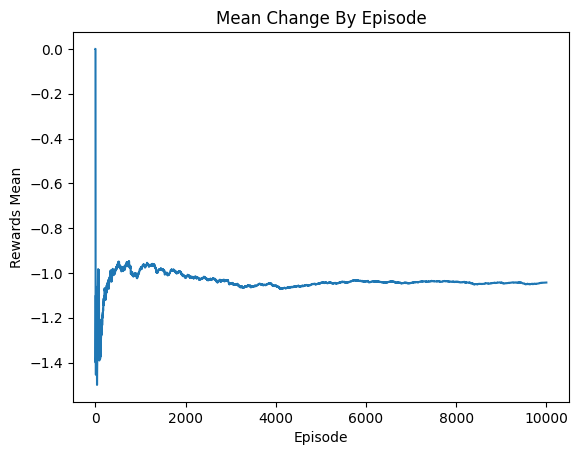

In [8]:
Stepwise_Mean = []

#EpisodeRewards = E_rewards.tolist()

for i in range(len(episode_rewards)):

    zero_to_step_i = episode_rewards[:i]

    Mean = np.mean(zero_to_step_i)

    Stepwise_Mean.append(Mean)

# Plot the episode rewards
plt.plot(Stepwise_Mean)
plt.xlabel('Episode')
plt.ylabel('Rewards Mean')
plt.title('Mean Change By Episode')
plt.show()